In [16]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas
import os

import settings

In [18]:
input_image_size = (2048, 1024) # => 2 * (1024, 1024) => 2* resized_to_img_size, because FCN
img_size = (128, 128)
num_classes = len(settings.labels)

In [19]:
batch_size = settings.BATCH_SIZE
shuffle_buffer_size = settings.SHUFFLE_BUFFER_SIZE

train_dataset_path = settings.TRAIN_DATASET_PATH
val_dataset_path = settings.VAL_DATASET_PATH
test_dataset_path = settings.TEST_DATASET_PATH

train_dataset = tf.data.Dataset.load(path=train_dataset_path)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)

val_dataset =  tf.data.Dataset.load(path=val_dataset_path)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size)

test_dataset = tf.data.Dataset.load(path=test_dataset_path)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size)

In [20]:
def downsample(x, filters, max_pooling):
    x = layers.Conv2D(filters, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters,  (3,3), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    skip_connection = x

    if max_pooling:
        x = layers.MaxPooling2D(pool_size = (2,2))(x)

    return x, skip_connection


def upsample(x, filters, apply_skip_connection = False ,skip_connection = None):
    x = layers.Conv2DTranspose(filters, (2,2), strides = (2,2), padding="same")(x)

    if apply_skip_connection:
       x = layers.concatenate([x, skip_connection], axis=3)

    x = layers.Conv2D(filters, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3,3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 128, 128, 32)         128       ['conv2d_23[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_22 (Activation)  (None, 128, 128, 32)         0         ['batch_normalization_22

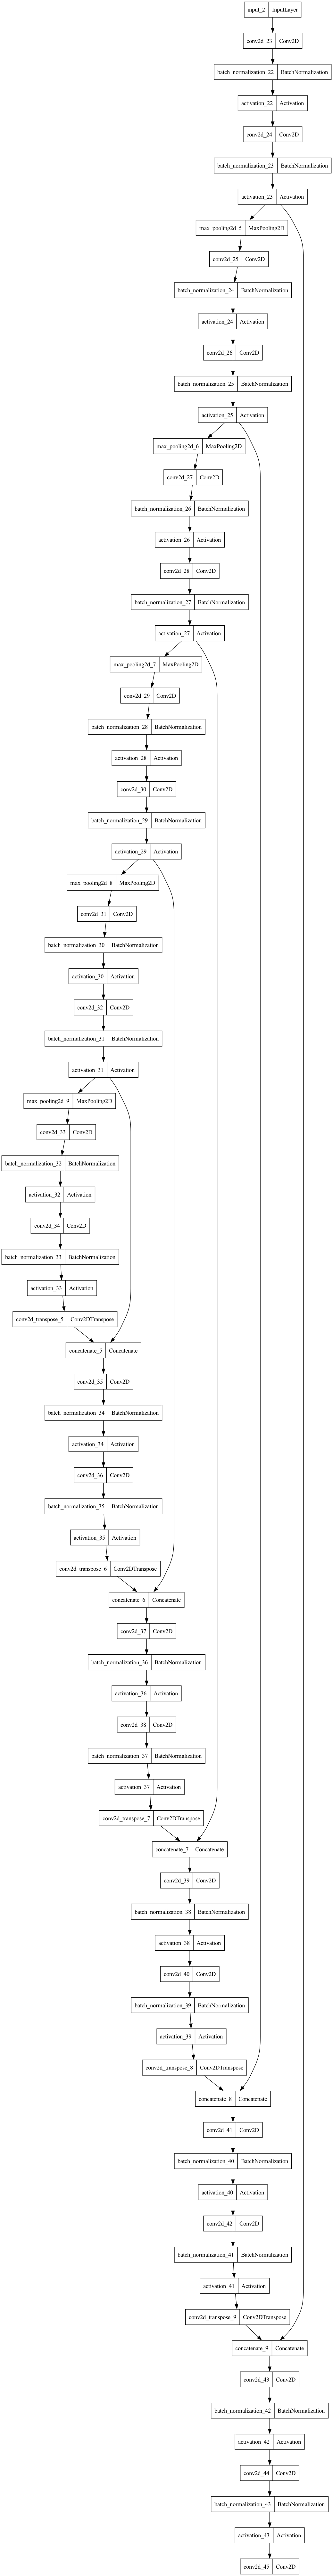

In [21]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    x, skip1  = downsample(inputs, 32, True)
    x, skip2  = downsample(x, 64, True)
    x, skip3  = downsample(x, 128, True)
    x, skip4  = downsample(x, 256, True)
    x, skip5  = downsample(x, 512, True)
    x, _      = downsample(x, 1024, False)


    x = upsample(x, 512, True, skip5)
    x = upsample(x, 256, True, skip4)
    x = upsample(x, 128, True, skip3)
    x = upsample(x, 64, True, skip2)
    x = upsample(x, 32, True, skip1)



    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()
tf.keras.utils.plot_model(model)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_filepath = settings.MODEL_CHECKPOINT_FILEPATH + 'Classic_UNet.keras'

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

model_checkpoint = ModelCheckpoint(model_checkpoint_filepath,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]




In [23]:
epochs = settings.EPOCHS

history = model.fit(train_dataset,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = val_dataset,
                    callbacks = callbacks)

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, epochs + 1, 5))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, epochs + 1, 5))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

In [25]:
model.load_weights(model_checkpoint_filepath) # load the best model weights

test_loss, test_accuracy = model.evaluate(test_dataset) # re-evaluate on the validation data

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*test_accuracy, 2)) + '\033[0m')

16/16 [==============================] - 71s 4s/step - loss: 0.5170 - accuracy: 0.8685

The model had an accuracy score of 86.85%!!


1/1 [==============================] - 0s 109ms/step


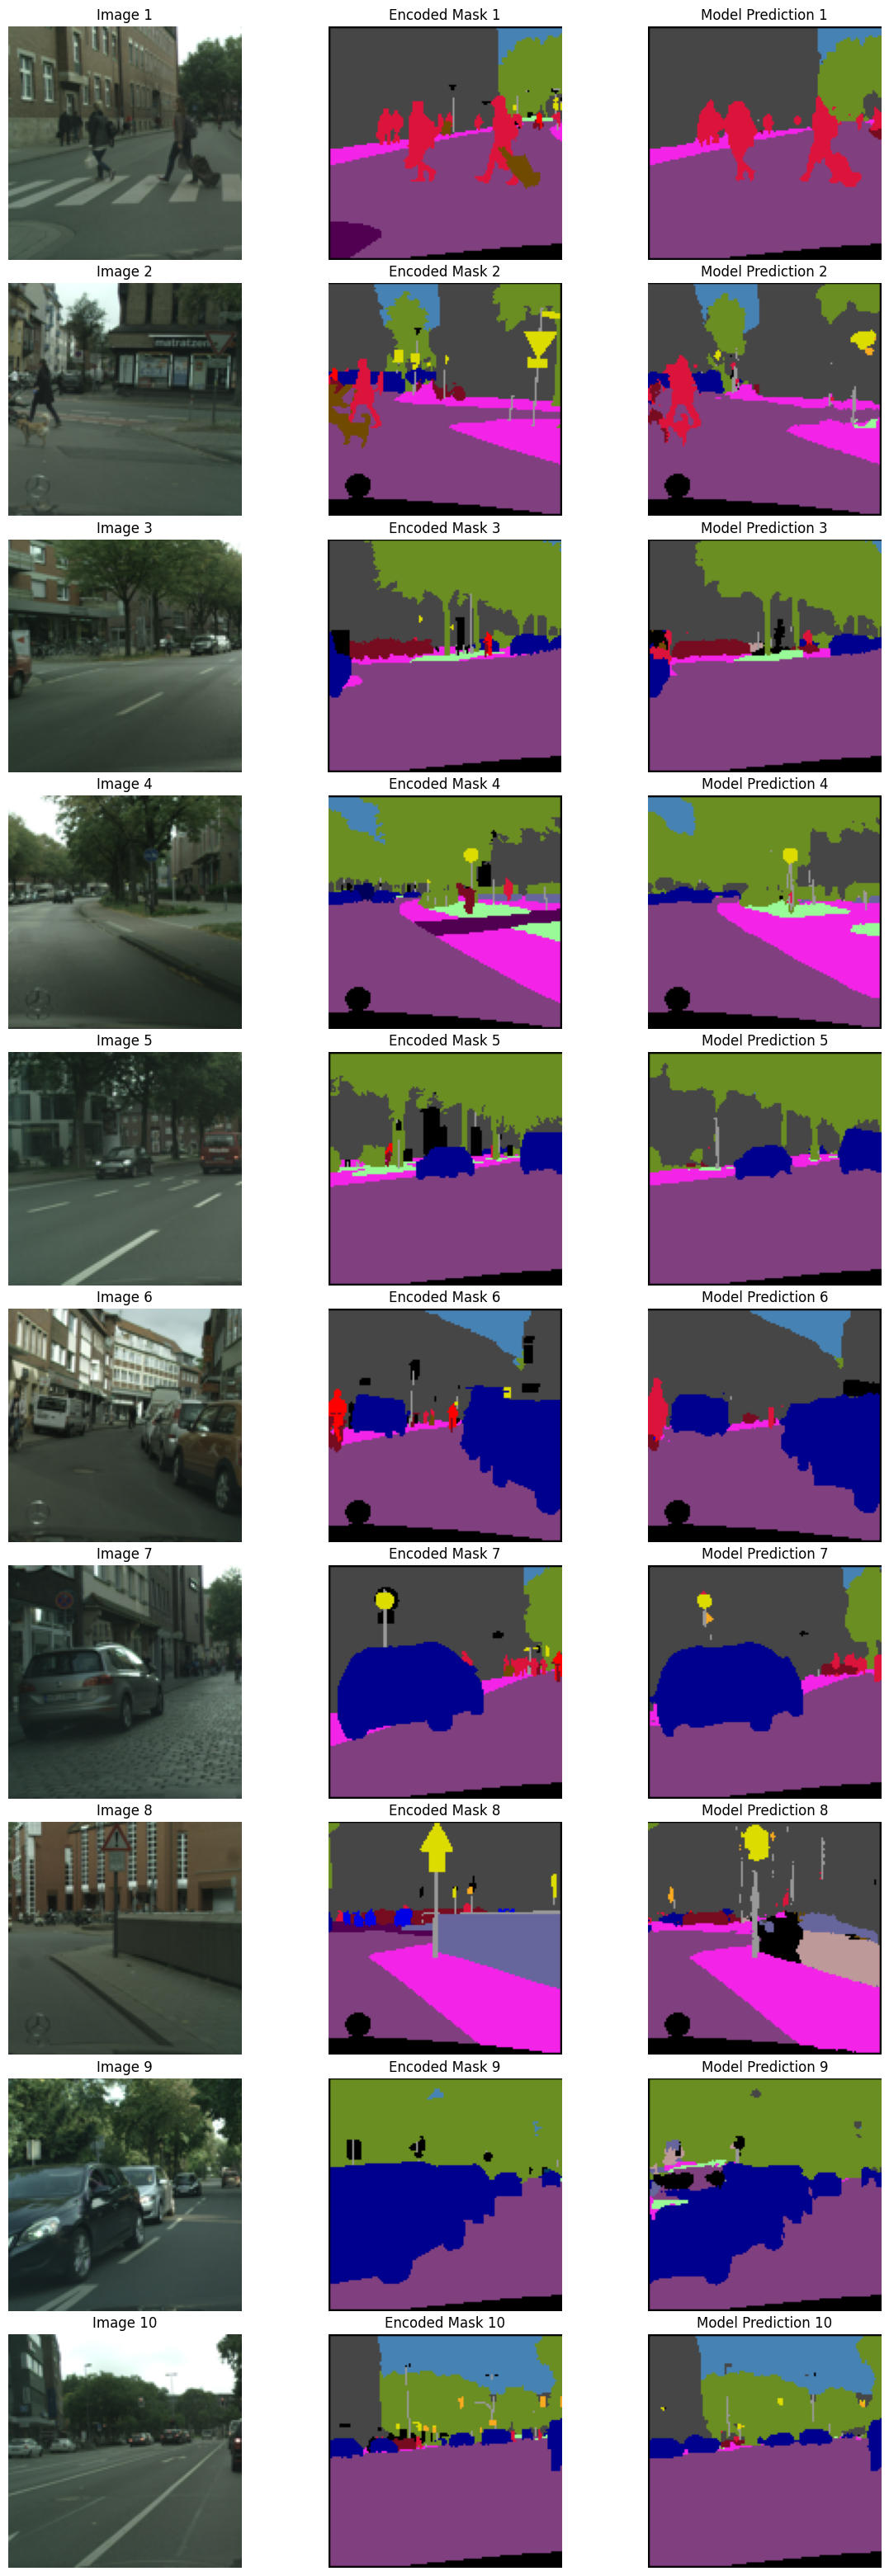

In [32]:
plt.figure(figsize=[15, 40])

unbatched = test_dataset.unbatch()
random_elements = unbatched.shuffle(buffer_size=100).take(10)
iterator = random_elements.as_numpy_iterator()

for i in range(10):
    pair = next(iterator)
    img = pair[0]
    enc = pair[1]

    pred = model.predict(img.reshape([1] + [128, 128, 3]))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])


    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = settings.id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')

            tmp2[row, col, :] = settings.id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')

    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

In [27]:
def preaty_mearge(img, enc):
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])

    for row in range(enc.shape[0]):
          for col in range(enc.shape[1]):
              tmp1[row, col, :] = settings.id2color[enc[row, col]]/255.0
              tmp1 = tmp1.astype('float32')

    # print(tmp1)

    return img*0.5 + tmp1*0.5

1/1 [==============================] - 0s 108ms/step


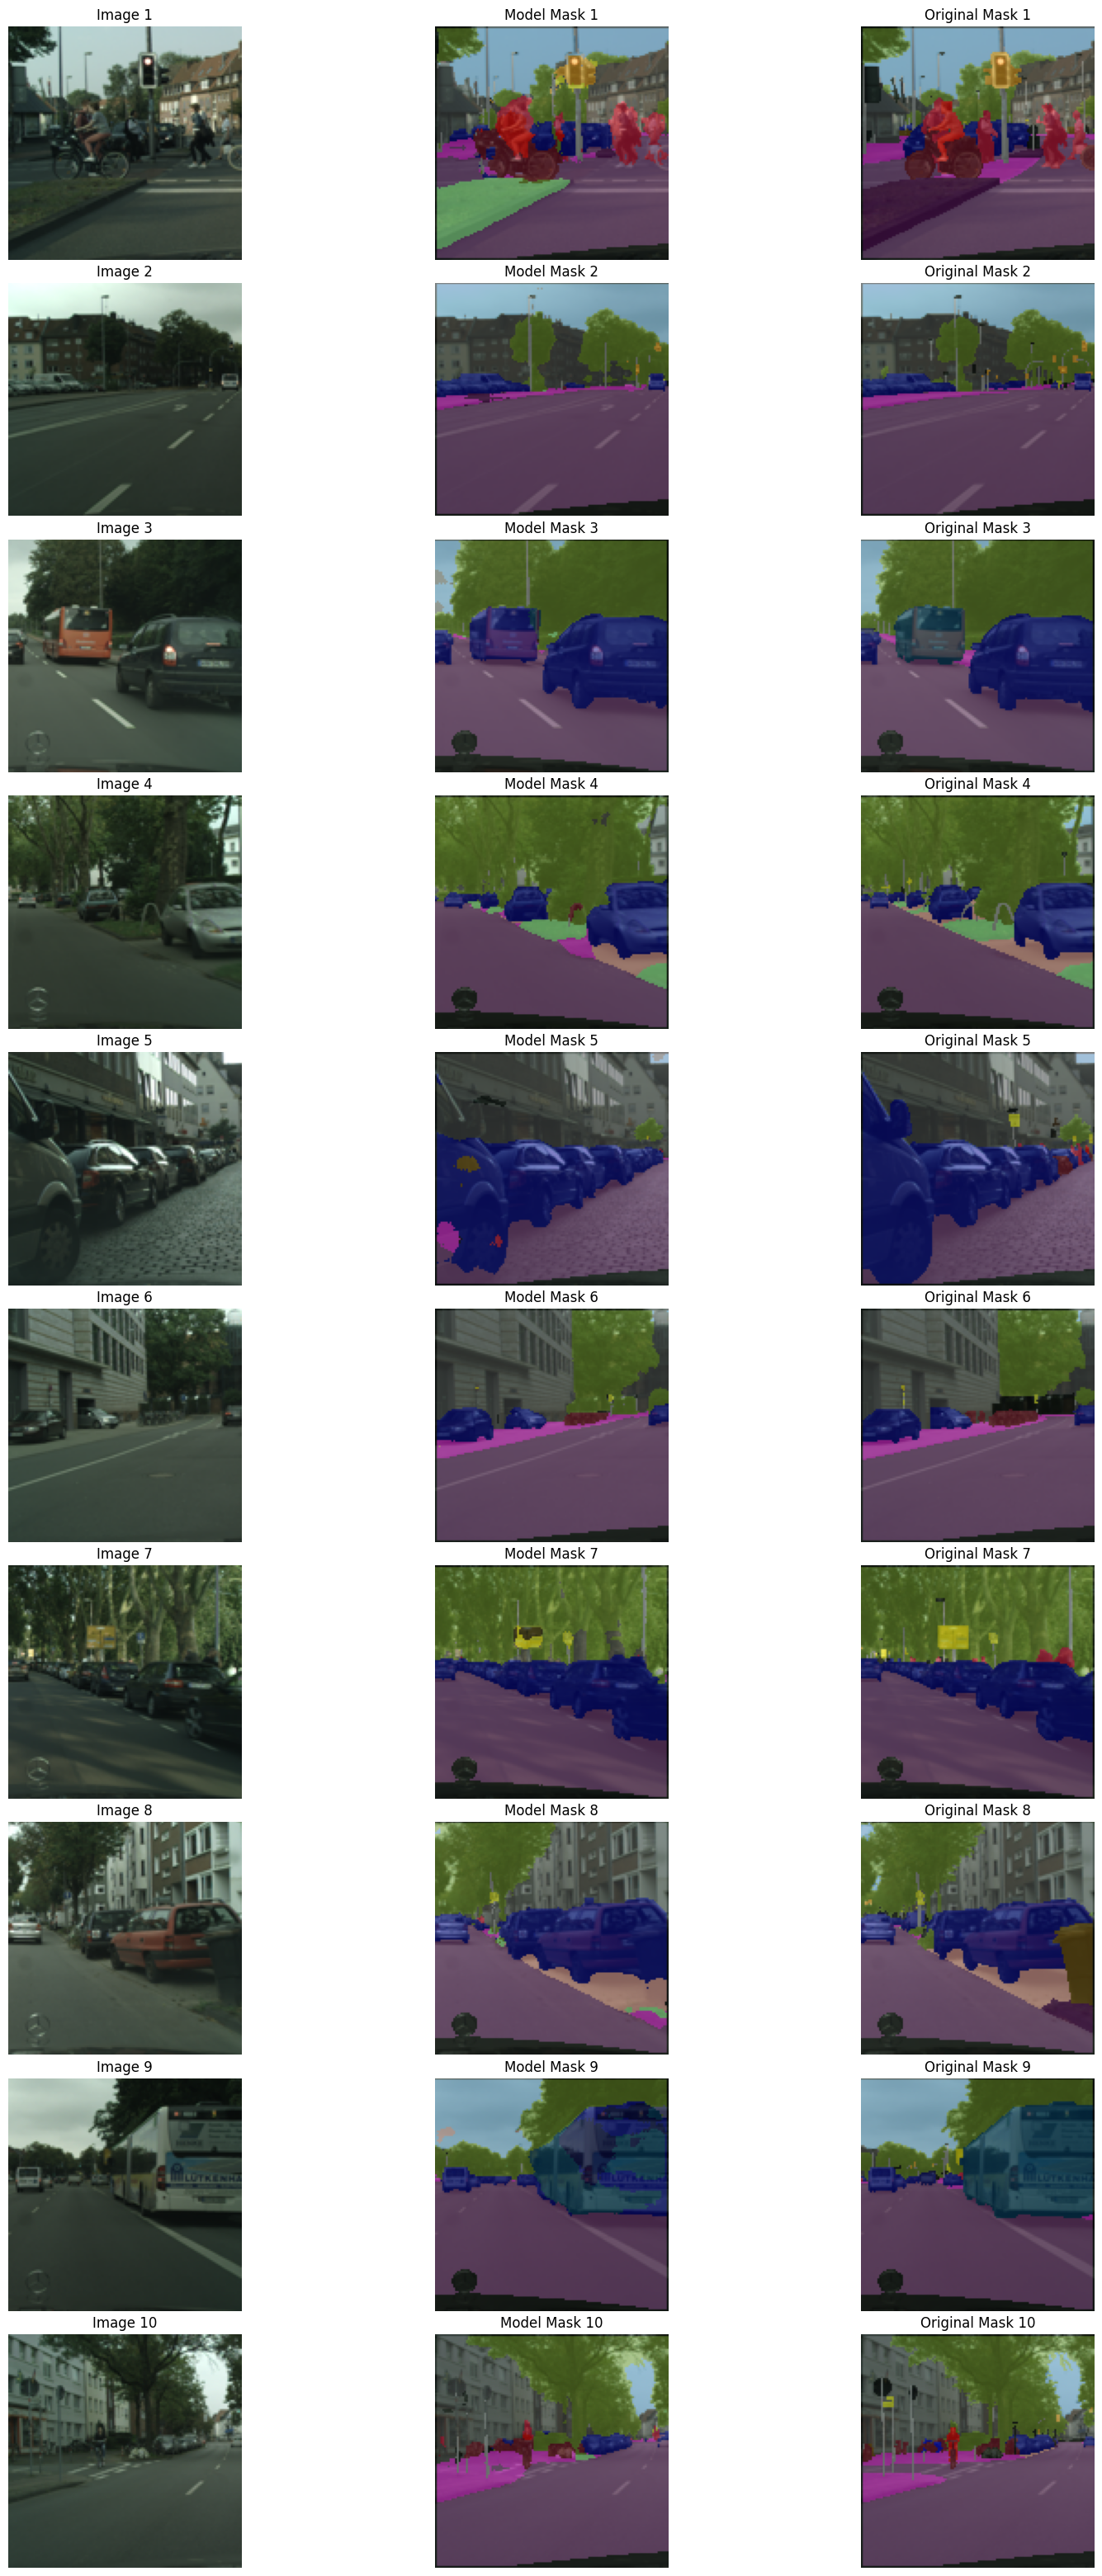

In [28]:
plt.figure(figsize=[20, 40])

unbatched = test_dataset.unbatch()
random_elements = unbatched.shuffle(buffer_size=100).take(10)
iterator = random_elements.as_numpy_iterator()

for i in range(10):
    pair = next(iterator)
    img = pair[0]
    enc = pair[1]

    pred = model.predict(img.reshape([1] + [128, 128, 3]))
    pred = np.squeeze(np.argmax(pred, axis=-1))

    tmp1 = preaty_mearge(img, pred)
    tmp2 = preaty_mearge(img, enc)




    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Model Mask {}'.format(str(i+1)))

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Original Mask {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

## PREDICT


In [29]:
count = 10
predict_dataset_path = settings.PRED_DATASET_PATH

predict_dataset = tf.data.Dataset.load(path=predict_dataset_path)

1/1 [==============================] - 0s 130ms/step


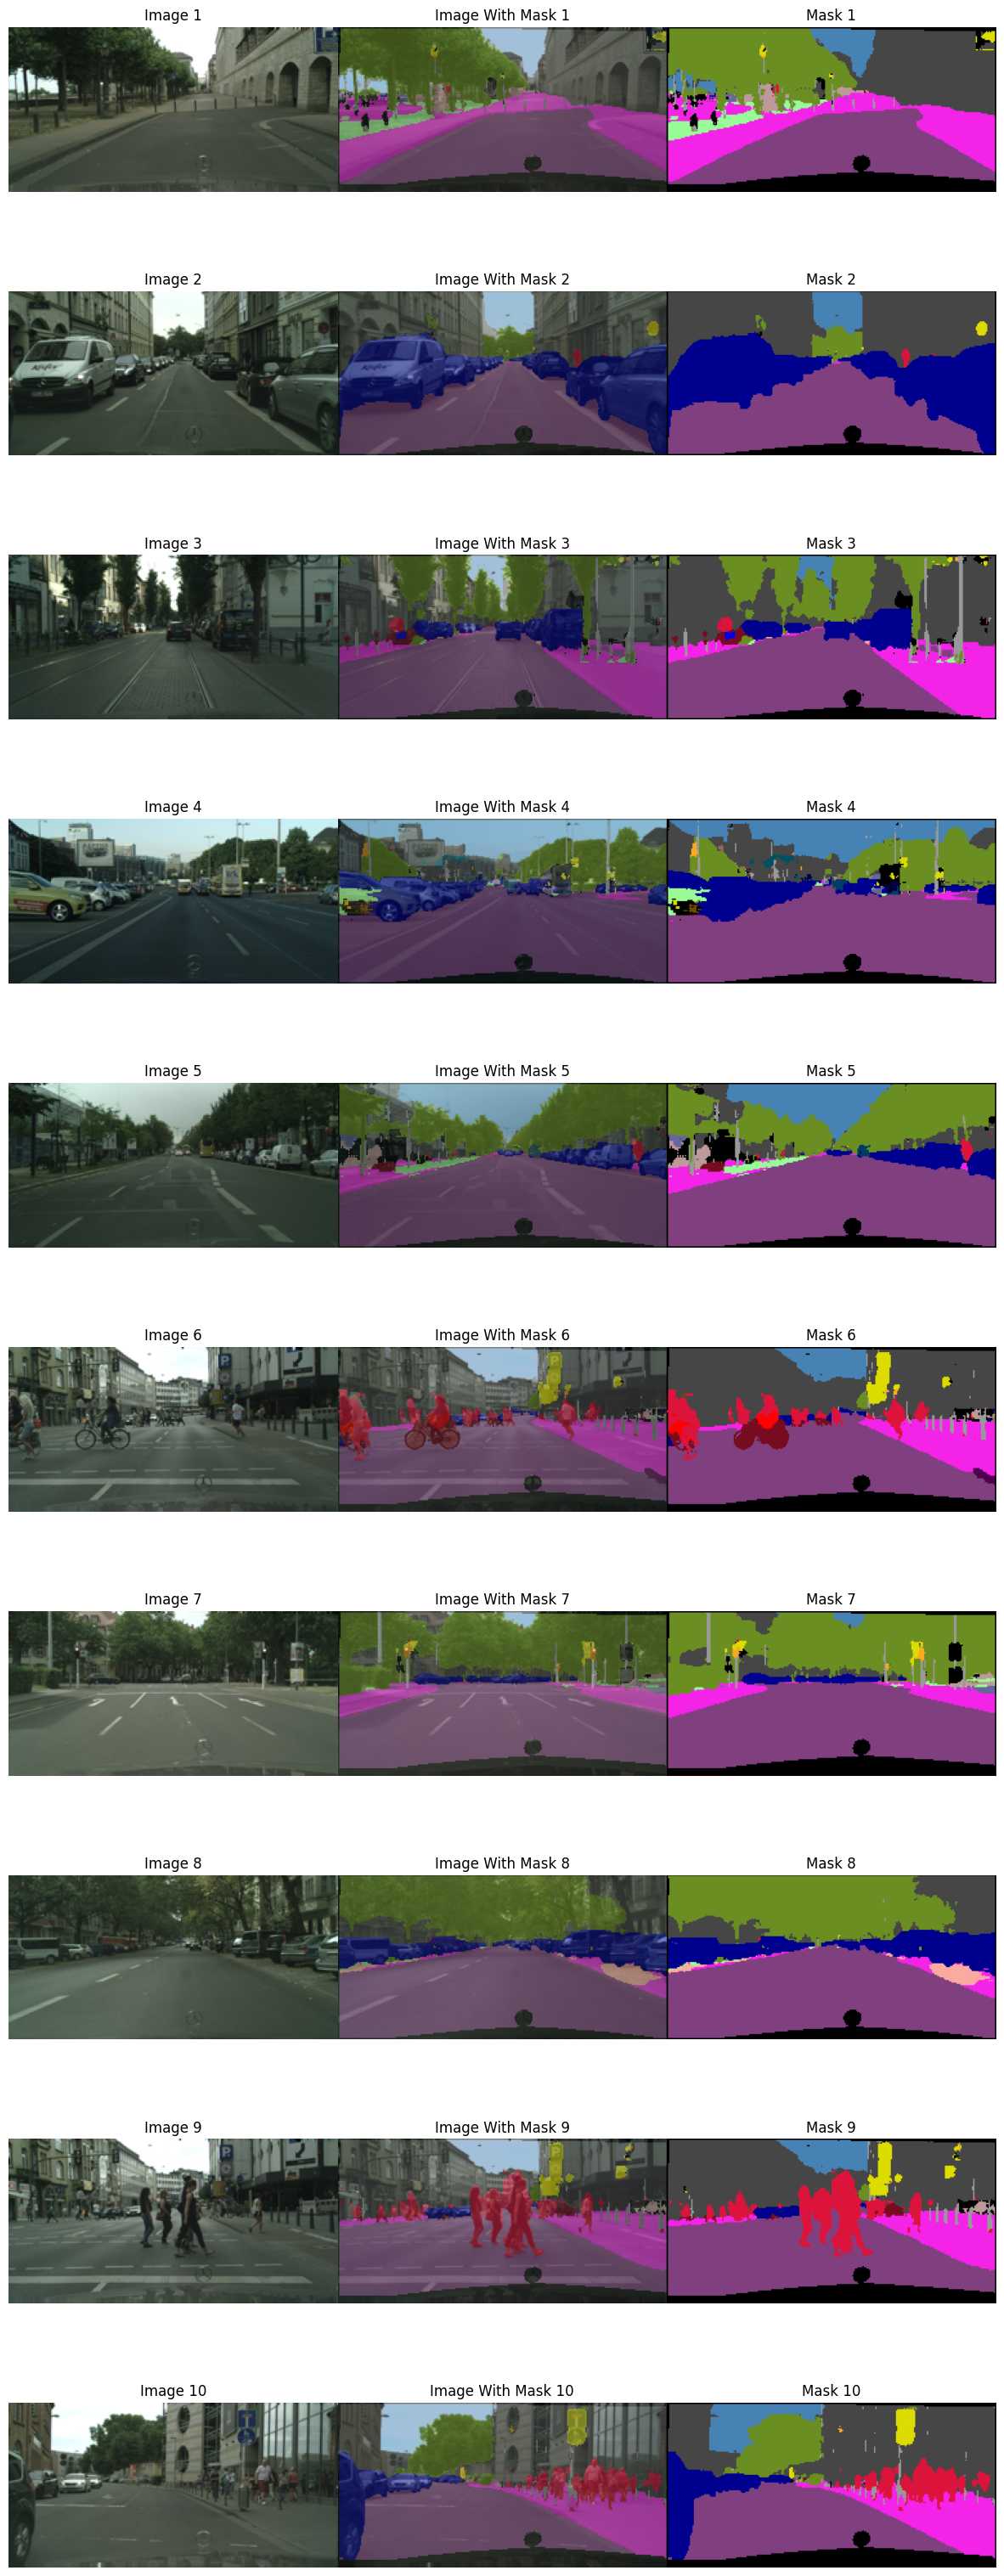

In [30]:
plt.figure(figsize=[15, 40])

random_elements = predict_dataset.shuffle(buffer_size=10).take(count)
iterator = random_elements.as_numpy_iterator()

for i in range(count):
    img_np = next(iterator)

    img = Image.fromarray(np.array(img_np))
    # display(img)

    left, right = img.crop([0, 0, 512, 512]), img.crop([512, 0, 1024, 512])


    left = left.resize([128, 128])
    right = right.resize([128, 128])
    left = np.array(left).astype('float32')/255.0
    right = np.array(right).astype('float32')/255.0

    concat = np.concatenate((left, right), axis=1)


    l_pred = model.predict(left.reshape([1] + [128, 128, 3]))
    l_pred = np.squeeze(np.argmax(l_pred, axis=-1))
    r_pred = model.predict(right.reshape([1] + [128, 128, 3]))
    r_pred = np.squeeze(np.argmax(r_pred, axis=-1))

    # r_pred = r_pred.resize(128, 128)
    # l_pred = l_pred.resize(128, 128)

    result = np.concatenate((l_pred, r_pred), axis=1)


    mask = np.zeros([result.shape[0], result.shape[1], 3])
    for row in range(result.shape[0]):
        for col in range(result.shape[1]):
            mask[row, col, :] = settings.id2color[result[row, col]]/255.0
            mask = mask.astype('float32')

    tmp = preaty_mearge(concat, result)

    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(concat)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))

    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Image With Mask {}'.format(str(i+1)))

    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(mask)
    plt.axis('off')
    plt.gca().set_title('Mask {}'.format(str(i+1)))

plt.subplots_adjust(wspace=0, hspace=0.1)

